In [10]:
# related library
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import geopandas as gpd

import ipywidgets
from ipywidgets import widgets 
from ipywidgets import *  
from IPython.display import display,clear_output

from ipywidgets import Layout
from traitlets import directional_link

from datetime import datetime
from datetime import date
from dateutil import rrule

In [16]:
ipywidgets.__version__


NameError: name 'ipython' is not defined

In [11]:
# prepare data for dropdown: continent list and country list

# get world info
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# get continent list plus "all"
continent_list = ["all"] + list(set(world['continent']))
#continent_list.append("all")

continent_country_dict = {}
for continent in continent_list:
    continent_country_dict[continent] = ["all"] + list(world[world['continent']== continent]['name'])
    #continent_country_dict[continent].append("all")
    
print ("continent list for dropdown:")
print (continent_list)

continent list for dropdown:
['all', 'Seven seas (open ocean)', 'South America', 'North America', 'Antarctica', 'Asia', 'Oceania', 'Europe', 'Africa']


# load dataset

In [3]:
#t_people = pd.read_csv("talk_score_file/people_score_date_geo.csv")

In [4]:
#t_events = pd.read_csv("talk_score_file/events_score_date_geo.csv")

In [17]:
a_people = pd.read_csv("score_file/people_score_date_geo.csv")

In [18]:
a_events = pd.read_csv("score_file/events_score_date_geo.csv")

In [19]:
complete_df = {}
complete_df['Articles'] = {}
complete_df['Talks'] = {}
complete_df['Articles']['People'] = a_people
complete_df['Articles']['Events'] = a_events
#complete_df['Talks']['People'] = t_people
#complete_df['Talks']['Events'] = t_events

# side function

Please run it first

In [20]:
def exclude_BC(df):
    bc_list = [one for one in df['date'] if one.startswith("-")]
    df_withoutBC = df[~df['date'].isin(bc_list)]
    #print ("There are %d dates before Christ,%d entities left after excluding"%(len(bc_list),len(df_withoutBC)))
    return df_withoutBC

In [21]:
def add_datetime_column(df,unit):
    # unit: date,month,year
    datetime_format = ""
    if unit == "date":
        datetime_format = "%Y-%m-%d"
    elif unit == "month":
        datetime_format = "%Y-%m"
    elif unit == "year":
        datetime_format = "%Y"
    new_list = [datetime.strptime(one,datetime_format) for one in df[unit]]
    if unit == "date":
        df = df.assign(datetime_date=pd.Series(new_list).values)
    elif unit == "month":
        df = df.assign(datetime_month=pd.Series(new_list).values)
    elif unit == "year":
        df = df.assign(datetime_year=pd.Series(new_list).values)
    return df

In [22]:
def add_month_column(df):
    new_list = [one[:7] for one in df['date']]
    df = df.assign(month=pd.Series(new_list).values)
    return df

In [23]:
def add_year_column(df):
    new_list = [one[:4] for one in df['date']]
    df = df.assign(year=pd.Series(new_list).values)
    return df

In [24]:
def score_median_group_by_column(df,tcn,scn):
    #print (df)
    out_df = df.groupby(tcn).agg({scn:np.median}).reset_index()
    #print (df)
    return out_df
# df_month_score=score_median_group_by_column(monthSenti,'month','score')
# print (df_month_score.head())

In [25]:
def score_percentile_group_by_column(df,tcn,scn,percentile):
    #print (df)
    out_df = df.groupby(tcn).quantile(percentile).reset_index()
    #print (out_df)
    return out_df

In [78]:
# plot function
def prepare_flowplot_percentiles(lexicon,sentiment,group,domain,geo,times,ra,window,unit):
    # lexicon,sentiment,group,domain,geo,time,ra,unit
    # lexicon: OL, MPQA, LIWC, ANEW
    # sentiment: pos, neg, total
    # group: [group_people,group_events,group_others] boolean value
    # domain: Articles, Talks
    # geo: [continent,country] continent,country could be 'all'
    # times: [start_year,start_month,end_year,end_month] int
    # unit: 'year' or 'month'
    
    # output_text
    statistics = []
    dict_a_people = {"total":"1,146,257","date":"775,664","BC":"27"}
    dict_a_events = {"total":"54,071","date":"22,582","BC":"33"}
    statistics_dict = {"Articles":{"People":dict_a_people,"Events":dict_a_events},"Talks":{"People":{},"Events":{}}}
    birth_occurrance = {"People":"birth","Events":"occurrance"}
    
    # prepare showed dates depending on time range
    # get time range
    start_yy,start_mm,end_yy,end_mm = times
    start_date = date(start_yy,start_mm,1)
    end_date = date(end_yy,end_mm,1)
    # prepare x-axis
    xaxis_value = [day for day in rrule.rrule(rrule.DAILY,dtstart=start_date,until=end_date)]
    #print ("value for x-axis looks like this: \n%s \nlen(x-axis): %d"%(xaxis_value[-1],len(xaxis_value)))
    
    # prepare dataframe to display
    df = pd.DataFrame()
    
    #group_people,group_events,group_others = group
    
    # choose corresponding dataframe depend on domain and group
    for one in group:
        if one.value:
            # add statistics for total entities for this group
            statistics.append("There are totally %s %s entities in Wikipedia %s."%(statistics_dict[domain][one.description]['total'],one.description,domain))
            statistics.append("Among them, %s have %s date information. Inside them we exclude %s entities whose date before Christ (BC)."%
                              (statistics_dict[domain][one.description]['date'],birth_occurrance[one.description],statistics_dict[domain][one.description]['BC']))
            if df.empty:
                df = complete_df[domain][one.description][['pos_score_'+lexicon,'neg_score_'+lexicon,'date','country','continent']]
            else:
                df = pd.concat([df,complete_df[domain][one.description][['pos_score_'+lexicon,'neg_score_'+lexicon,'date','country','continent']]])

    statistics.append("After all, there are {:,d} entities with AC date information in this run.".format(len(df)))
    # filter out entities based on geo
    continent,country = geo
    # if continent == 'all', do nothing
    if not continent == 'all':
        if country == 'all':
            # filter out entities with target continent
            df = df[df['continent']==continent]
        else:
            # filter out entities with target country
            df = df[df['country']==country]
    statistics.append("After filtering with area, there are {:,d} entities left.".format(len(df)))
          
    # add target unit and corresponding datetime type for entities
    if unit == "month":
        df = add_month_column(df)
    elif unit == "year":
        df = add_year_column(df)
        
    # we need datetime type because we use it to filter out entities within time range
    df = add_datetime_column(df,unit)
    
    # filter out entities based on time range
    df = df[df["datetime_"+unit].isin(xaxis_value)]
    statistics.append("After filtering with date, there are {:,d} entities left, and collected in the plot.".format(len(df)))
    
    # get score depending on lexicon and sentiment
    if sentiment == "total":
        df = df.assign(total=df["pos_score_"+lexicon]+df["neg_score_"+lexicon])
        score_column = "total"
    else:
        score_column = sentiment+"_score_"+lexicon

    # plot flowplot    
    # get median
    df_median = score_median_group_by_column(df,unit,score_column)
    df_median = add_datetime_column(df_median,unit)
    df_25percentile = score_percentile_group_by_column(df,unit,score_column,0.25)
    df_75percentile = score_percentile_group_by_column(df,unit,score_column,0.75)
    
    if ra == True:
        # get rolling average
        df_median["ra"] = df_median[score_column].rolling(window,center=True).mean()
        df_25percentile["ra"] = df_25percentile[score_column].rolling(window,center=True).mean()
        df_75percentile["ra"] = df_75percentile[score_column].rolling(window,center=True).mean()    
    
    # plot flowplot
    #ax.plot(df_median['datetime_'+unit],df_median[score_column],'r-')
    temp_x = df_median['datetime_'+unit]
    temp_x = pd.Series.as_matrix(temp_x)
    #ax.fill_between(temp_x,df_25percentile[score_column],df_75percentile[score_column],color='b',alpha=0.2)
    
    df_time_size = df.groupby(unit).size().reset_index(name='size')
    
    return df_median,df_25percentile,df_75percentile,score_column,temp_x,df_time_size,statistics

#     # set ax
#     myfontsize = 10
#     ax.set_title("median,percentile of "+sentiment+" score for "+group+" based on "+lexicon,fontsize=myfontsize)
#     ax.set_xlabel('time')
#     ax.set_ylabel('score')
#     ax.set_xlim([start_date,end_date])
#     [[item.set_color('b') for item in bp_dict[key]['boxes']] for key in bp.keys()]
#     [[item.set_color('b') for item in bp_dict[key]['whiskers']] for key in bp.keys()]
#     [[item.set_color('r') for item in bp_dict[key]['medians']] for key in bp.keys()]
    
#     for tick in bp_axes.get_xticklabels():
#                 tick.set_rotation(90)
    #plt.show()
    
#flowplot_percentiles("OL","total","People",["Europe","all"],"Articles","month",[1940,1,1],[1960,1,1])

# widget 1: median of sentiment score for Wikipedia concepts over time grouped by month

In [15]:
# framework
#     lexicon container: Which lexicon you want to choose? (OL, MPQA, LIWC)
#         title html
#         radio_button
#     group container: Which group you want to show? (People, Events)
#         title html
#         checkboxes container:
#             checkbox
#             checkbox
#     area filter: Do you want to filter out the continent or country for entities?
#         title html
#         dropdown_continent
#         dropdown_country
#     domain container: What domain you want to use? (Article, Talks)
#         title html
#         checkboxes container:
#             radio_button
#     time filter: Set the start and stop of time range
#         dropdown
#         

# change label to HTML (for set style more flexible)
    
container_width = 'auto'
with_border_layout = Layout(border='solid 0.5px')


# preparing a container for header
header_container = widgets.VBox(layout=Layout(width='100%',border='solid 0.5px'))
header_text = """<h1>Time Widget 1</h1><br>
<p>This widget is used to show median of scores for Wikipedia concepts verying with time.</p><br>
<p>Wikipedia concepts (or Wikipedia entities) here contains Wikipedia articles and Wikipedia talks, which can be entered from upper left side of article pages.
This widget includes entities both People and Events, with people the date indicates birth date, while with events the date indicates occurrance date.
The text of Articles and Talks is extracted from Wikipedia Dump, and time stamps are extracted from DBPedia.
The scores are calculated with term frequency for sentiment words based on certain lexicons (OL, MPQA, LIWC, ANEW). For ANEW we take valency into account too.
</p><br>
<p>
For each run there will be two plots sharing x-axis. 
The second plot shows median (or rolling average of median) of scores based on your settings, and the first plot is the number of concepts for the corresponding time.
The time is splited with month as unit.
In the bottom you will get the data characteristics for the current run.</p>"""
html_header = widgets.HTML(value=header_text)
header_container.children=[html_header]


# for lexicon
lexicon_container = widgets.VBox(layout=Layout(width='90px',border='solid 0.5px'))
# add title
html_lexicon = widgets.HTML(value="<b>Lexicon</b>")
#label_lexicon = widgets.Label(value="sentiment lexicon")
# preparing a container to put in radio buttons
radio_button_lexicon = widgets.RadioButtons(
    options=['OL', 'MPQA', 'LIWC','ANEW'],
    #description='sentiment lexicon',
    #style=style,
    disabled=False
)
# put text and button into lexicon container
lexicon_container.children = [html_lexicon,radio_button_lexicon]


# for sentiment
sentiment_container = widgets.VBox(layout=lexicon_container.layout)
# add title
html_sentiment = widgets.HTML(value="<b>Sentiment</b>")
# preparing a container to put in radio buttons
radio_button_sentiment = widgets.RadioButtons(
    options=['total', 'positive', 'negative'],
    #description='',
    #style=style,
    disabled=False
)
# put text and button into lexicon container
sentiment_container.children = [html_sentiment,radio_button_sentiment]


# for target group
group_container = widgets.VBox(layout=lexicon_container.layout)
html_group = widgets.HTML(value="<b>Group</b>")
# checkboxes container
cb_container = widgets.VBox(layout=Layout(
)) 
# preparing a container to put in created checkbox
checkboxes = []  
# create checkbox
checkboxes.append(widgets.Checkbox(description = 'People', value=False))
checkboxes.append(widgets.Checkbox(description = 'Events', value=False))
# put check box into checkboxes container
cb_container.children=[i for i in checkboxes]
#display(cb_container)
# # add a new container to control the arrangement
# temp_container = widgets.HBox()
# temp = widgets.Label(description='choose target group')
# temp_container.children=[cb_container,temp]
group_container.children=[html_group,cb_container]


# for area 
area_container = widgets.VBox(layout=Layout(width='250px',border='solid 0.5px'))
html_area = widgets.HTML(value="<b>Geo</b>")
#dropdown_container = widgets.HBox()
#dropdown
dropdown_continent = widgets.Dropdown(
    options = continent_list,
    value = 'all',
    description='continent:',
    layout=Layout(width='240px'),
    disabled=False,
)  
dropdown_country = widgets.Dropdown(
    #options = country_list,
    description='country:',
    #options = ["all"],
    #value='all',
    layout=Layout(width='240px'),
    disabled = False,
)
def transform(case):
    return continent_country_dict[case]
directional_link((dropdown_continent,'value'),(dropdown_country,'options'),transform)
area_container.children=[html_area,dropdown_continent,dropdown_country]


# for domain
domain_container = widgets.VBox(layout=Layout(width=container_width,border='solid 0.5px'))
# add title
html_domain = widgets.HTML(value="<b>Domain</b>")
# preparing a container to put in radio buttons
radio_button_domain = widgets.RadioButtons(
    options=['Articles', 'Talks'],
    disabled=False
)
# put text and button into domain container
domain_container.children = [html_domain,radio_button_domain]


# for date
time_container = widgets.VBox(layout=Layout(width='280px',border='solid 0.5px'))
#add title
html_time = widgets.HTML(value="<b>Time</b>")
# prepare time year list
# dates = [day for day in rrule.rrule(rrule.YEARLY, dtstart=date(1700,1,1), until=date.today())]
# year_list = [(i.strftime('%Y'),i) for i in dates]
year_list = list(range(1900,2019,1))
month_list = list(range(1,13,1))
#time_list = [1940,1960,1992,1993]
dropdown_start_year = widgets.Dropdown(
    options = year_list,
    #description='start(year,month):',
    layout=Layout(width='80px'),
    #style={'description_width':'initial'},
    disabled=False,
)
dropdown_start_month = widgets.Dropdown(
    options = month_list,
    #description='',
    layout=Layout(width='40px'),
    disabled=False,
)
time_container_start = widgets.HBox()
time_container_start.children=[widgets.Label('start (year,month):'),dropdown_start_year,dropdown_start_month]

dropdown_end_year = widgets.Dropdown(
    options = year_list,
    #description='end(year,month):',
    #options = ["all"],
    value=year_list[-1],
    layout=Layout(width='80px'),
    disabled = False,
)
dropdown_end_month = widgets.Dropdown(
    options = month_list,
    #description='',
    #options = ["all"],
    #value=month_list[-1],
    layout=Layout(width='40px'),
    disabled = False,
)
time_container_end = widgets.HBox()
time_container_end.children = [widgets.Label('end (year,month):'),dropdown_end_year,dropdown_end_month]
time_container.children = [html_time,time_container_start,time_container_end]


# for rolling average
ra_container = widgets.VBox(layout=Layout(width='auto'))
#mystyle={'description_width':'initial'}
checkbox_ra = widgets.Checkbox(layout=Layout(width='20px'),value=False)
checkbox_ra_container = widgets.HBox()
checkbox_ra_container.children = [checkbox_ra, widgets.Label('Rolling average')]
ra_list = list(range(3,50,1))
dropdown_ra = widgets.Dropdown(
    options = ra_list,
    #description='windows size:',
    #options = ["all"],
    #value=year_list[-1],
    layout=Layout(width='50px'),
    disabled = True,
)
dropdown_ra_container = widgets.HBox()
dropdown_ra_container.children = [widgets.Label('window size:'),dropdown_ra]
def transform_ra(case):
    return {True:False,False:True}[case]

directional_link((checkbox_ra,'value'),(dropdown_ra,'disabled'),transform_ra)
ra_container.children = [checkbox_ra_container,dropdown_ra_container]


#for button
update_container = widgets.VBox(layout=Layout(#display='flex',
                                              #flex_flow='column',
                                              align_items='center',
                                              #width='100%',
                                              width=container_width,
                                              #border='solid 0.5px'
))
#add button that updates the graph based on the checkboxes
button = widgets.Button(description="Go")
update_container.children=[ra_container,button]


# preparing a container for input panel
input_container = widgets.HBox(layout=Layout(
    display='flex',
    flex_flow='row',
    align_items='stretch',
    border='solid 0.5px',
    #height='120px'
    #width='30%'
))
input_container.children=[lexicon_container, sentiment_container,group_container,domain_container,area_container,time_container,update_container]


# for plot
box_out = ipywidgets.Output(layout=Layout(width='100%',height='500px',border='solid 0.5px'))
import plotly.graph_objs as go
import plotly.plotly as py

import numpy as np

trace1 = go.Scatter(
    y = np.random.randn(500),
    mode='markers',
    marker=dict(
        size=16,
        color = np.random.randn(500), #set color equal to a variable
        colorscale='Viridis',
        showscale=True
    )
)
data = [trace1]
with box_out:
    py.iplot(data, filename='scatter-plot-with-colorscale')
# for out_text
#label_out = widgets.Label(value="Here is the statistics of output...",layout=Layout(width='100%'))
text_out = widgets.Output(layout=Layout(width='100%',border='solid 0.5px'))


# for output
output_container = widgets.VBox(layout=Layout(border='solid 0.5px'))
output_container.children = [box_out,text_out]


# container for all: including header, input and output two sections
all_container = widgets.VBox(layout=with_border_layout)
all_container.children = [header_container,input_container,output_container]

sen_dict = {"total":"total","positive":"pos","negative":"neg"}
display(all_container)

In [76]:
# define actions while click update botton
def on_button_clicked(b):
    # prepare and filter dataset
    # get parameters from input
    # get geo
    continent = dropdown_continent.value
    country = dropdown_country.value
    geo = [continent,country]
    # get time
    time_start_year = dropdown_start_year.value
    time_start_month = dropdown_start_month.value
    time_end_year = dropdown_end_year.value
    time_end_month = dropdown_end_month.value
    time = [time_start_year,time_start_month,time_end_year,time_end_month]
    # get lexicon
    lexicon = radio_button_lexicon.value
    # get sentiment
    sentiment = sen_dict[radio_button_sentiment.value]
    # get domain
    domain = radio_button_domain.value
    # get group
    # group_people,group_events,group_others = cb_container.children
    group = cb_container.children
    # get rolling average
    ra = checkbox_ra.value
    window = dropdown_ra.value
    
    # define time unit to month
    unit = "month"
    
    # output text
    #output_label_list = []
    output_label_str_container = widgets.VBox(layout=Layout(width='100%',border='solid 1px'))
    
    df50,df25,df75,score_column,percentile_x,df_time_size,output_label_list =prepare_flowplot_percentiles(lexicon,sentiment,group,domain,geo,time,ra,window,unit)
    
    # if rolling average==True, get column 'ra' instead of 
    if ra == True:
        score_column = 'ra'
        
    # draw
    fig,axes = plt.subplots(2,1,sharex='all',figsize=(15,8))
    ax0,ax1 = axes.flatten()
    ax = [ax0,ax1]
    ax[0].bar(df50['datetime_'+unit].tolist(),df_time_size['size'],width=33)
    ax[1].plot(df50['datetime_'+unit],df50[score_column],'r-')
    ax[1].fill_between(percentile_x,df25[score_column],df75[score_column],color='b',alpha=0.2)
    
    #output_label_list.append("Totally %d entities are collected in the plot."%(sum(df_time_size['size'].tolist())))
    output_labels = [widgets.HTML(value=i) for i in output_label_list]
    output_label_str_container.children = [i for i in output_labels]
    with box_out:
        clear_output(wait=True)
        display(fig)
    with text_out:
        clear_output(wait=True)
        display(output_label_str_container)
    plt.close(fig)

In [13]:
# run the widget
# with text_out:
#     display(label_out)
display(all_container)
#button.on_click(on_button_clicked)

# widget 2: sentiment score for identical Wikipedia concepts over time

In [27]:
# plot function
def prepare_scatter(lexicon,sentiment,group,domain,geo,times,unit):
    # lexicon,sentiment,group,domain,geo,time,ra,unit
    # lexicon: OL, MPQA, LIWC, ANEW
    # sentiment: pos, neg, total
    # group: [group_people,group_events,group_others] boolean value
    # domain: Articles, Talks
    # geo: [continent,country] continent,country could be 'all'
    # times: [start_year,start_month,end_year,end_month] int
    # unit: 'year' or 'month'
    
    # prepare showed dates depending on time range
    # get time range
    start_yy,start_mm,end_yy,end_mm = times
    start_date = date(start_yy,start_mm,1)
    end_date = date(end_yy,end_mm,1)
    # prepare x-axis
    xaxis_value = [day for day in rrule.rrule(rrule.DAILY,dtstart=start_date,until=end_date)]
    #print ("value for x-axis looks like this: \n%s \nlen(x-axis): %d"%(xaxis_value[-1],len(xaxis_value)))
    
    # prepare dataframe to display
    df = pd.DataFrame()
    
    #group_people,group_events,group_others = group
    
    # choose corresponding dataframe depend on domain and group
    for one in group:
        if one.value:
            if df.empty:
                df = complete_df[domain][one.description][['pos_score_'+lexicon,'neg_score_'+lexicon,'date','country','continent']]
            else:
                df = pd.concat([df,complete_df[domain][one.description][['pos_score_'+lexicon,'neg_score_'+lexicon,'date','country','continent']]])

        
    # filter out entities based on geo
    continent,country = geo
    # if continent == 'all', do nothing
    if not continent == 'all':
        if country == 'all':
            # filter out entities with target continent
            df = df[df['continent']==continent]
        else:
            # filter out entities with target country
            df = df[df['country']==country]

          
    # add target unit and corresponding datetime type for entities
    if unit == "month":
        df = add_month_column(df)
    elif unit == "year":
        df = add_year_column(df)
        
    # we need datetime type because we use it to filter out entities within time range
    df = add_datetime_column(df,unit)
    
    # filter out entities based on time range
    df = df[df["datetime_"+unit].isin(xaxis_value)]
    
    # get score depending on lexicon and sentiment
    df = df.assign(total=df["pos_score_"+lexicon]+df["neg_score_"+lexicon])
    df = df.assign(final=df["pos_score_"+lexicon]-df["neg_score_"+lexicon])
    
    return df


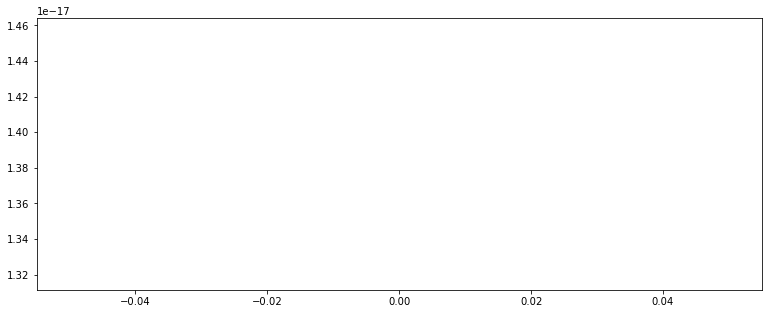

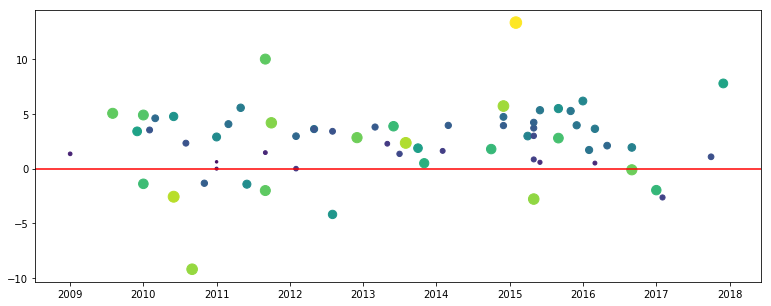

In [31]:
# design the panel: map panel and side panel
# for map panel:
#     map
#
# for columns
#     lexicon container: Which lexicon you want to choose? (OL, MPQA, LIWC)
#         title label
#         radio_button
#     group container: Which group you want to show? (People, Events, Others)
#         title label
#         checkboxes container:
#             checkbox
#             checkbox
#             checkbox
#     area filter: Do you want to filter out the continent or country for entities?
#         title label
#         dropdown_continent
#         dropdown_country
#     domain container: What domain you want to use? (Article, Talks)
#         title label
#         checkboxes container:
#             checkbox
#             checkbox
#             checkbox
#     time filter: Set the start and stop of time range
#         
#         

#plt.style.use('ggplot')

# change label to HTML (for set style more flexible)
    
import matplotlib 
container_width = 'auto'
with_border_layout = Layout(border='solid 0.5px')


# preparing a container for header
header_container = widgets.VBox(layout=Layout(width='100%'))
html_header = widgets.HTML(value="<b>Time Widget 1</b>")
header_container.children=[html_header]


# preparing a container for input panel
input_container = widgets.HBox(layout=Layout(
    display='flex',
    flex_flow='row',
    align_items='stretch',
    border='solid 0.5px',
    #height='120px'
    #width='30%'
)
)


# for lexicon
# lexicon container for lexicons
lexicon_container = widgets.VBox(layout=Layout(width='90px',border='solid 0.5px'))
# add title
html_lexicon = widgets.HTML(value="<b>Lexicon</b>")
#label_lexicon = widgets.Label(value="sentiment lexicon")
# preparing a container to put in radio buttons
radio_button_lexicon = widgets.RadioButtons(
    options=['OL', 'MPQA', 'LIWC','ANEW'],
    #description='sentiment lexicon',
    #style=style,
    disabled=False
)
# put text and button into lexicon container
lexicon_container.children = [html_lexicon,radio_button_lexicon]


# for sentiment
# lexicon container for lexicons
sentiment_container = widgets.VBox(layout=lexicon_container.layout)
# add title
html_sentiment = widgets.HTML(value="<b>Sentiment</b>")
# preparing a container to put in radio buttons
radio_button_sentiment = widgets.RadioButtons(
    options=['total', 'positive', 'negative'],
    #description='',
    #style=style,
    disabled=False
)
# put text and button into lexicon container
sentiment_container.children = [html_sentiment,radio_button_sentiment]


# for target group
# container for groups
group_container = widgets.VBox(layout=lexicon_container.layout)
html_group = widgets.HTML(value="<b>Group</b>")
# checkboxes container
cb_container = widgets.VBox(layout=Layout(
)) 
# preparing a container to put in created checkbox
checkboxes = []  
# create checkbox
checkboxes.append(widgets.Checkbox(description = 'People', value=False))
checkboxes.append(widgets.Checkbox(description = 'Events', value=False))
checkbox_others = widgets.Checkbox(description = 'Others', value=False)
checkboxes.append(checkbox_others)
# put check box into checkboxes container
cb_container.children=[i for i in checkboxes]
#display(cb_container)
# # add a new container to control the arrangement
# temp_container = widgets.HBox()
# temp = widgets.Label(description='choose target group')
# temp_container.children=[cb_container,temp]
group_container.children=[html_group,cb_container]


# for area filter
#container for area
area_container = widgets.VBox(layout=Layout(width='250px',border='solid 0.5px'))
html_area = widgets.HTML(value="<b>Geo</b>")
#dropdown_container = widgets.HBox()
#dropdown
dropdown_continent = widgets.Dropdown(
    options = continent_list,
    value = 'all',
    description='continent:',
    layout=Layout(width='240px'),
    disabled=False,
)  
dropdown_country = widgets.Dropdown(
    #options = country_list,
    description='country:',
    #options = ["all"],
    #value='all',
    layout=Layout(width='240px'),
    disabled = False,
)

def transform(case):
    return continent_country_dict[case]

directional_link((dropdown_continent,'value'),(dropdown_country,'options'),transform)

#l = traitlets.link((dropdown_continent,'value'),(dropdown_country,'value'))
#dropdown_container.children = [dropdown_continent,dropdown_country]
area_container.children=[html_area,dropdown_continent,dropdown_country]


# for domain
# domain container for article/talkpage
domain_container = widgets.VBox(layout=Layout(width=container_width,border='solid 0.5px'))
# add title
html_domain = widgets.HTML(value="<b>Domain</b>")
# preparing a container to put in radio buttons
radio_button_domain = widgets.RadioButtons(
    options=['Articles', 'Talks'],
    disabled=False
)
# put text and button into domain container
domain_container.children = [html_domain,radio_button_domain]


time_container = widgets.VBox(layout=Layout(width='280px',border='solid 0.5px'))
#add title
html_time = widgets.HTML(value="<b>Time</b>")
# prepare time year list
# dates = [day for day in rrule.rrule(rrule.YEARLY, dtstart=date(1700,1,1), until=date.today())]
# year_list = [(i.strftime('%Y'),i) for i in dates]
year_list = list(range(1900,2019,1))
month_list = list(range(1,13,1))
#time_list = [1940,1960,1992,1993]
dropdown_start_year = widgets.Dropdown(
    options = year_list,
    value=year_list[-10],
    #description='start(year,month):',
    layout=Layout(width='80px'),
    #style={'description_width':'initial'},
    disabled=False,
)
dropdown_start_month = widgets.Dropdown(
    options = month_list,
    #description='',
    layout=Layout(width='40px'),
    disabled=False,
)
time_container_start = widgets.HBox()
time_container_start.children=[widgets.Label('start (year,month):'),dropdown_start_year,dropdown_start_month]
    
dropdown_end_year = widgets.Dropdown(
    options = year_list,
    #description='end(year,month):',
    #options = ["all"],
    value=year_list[-1],
    layout=Layout(width='80px'),
    disabled = False,
)
dropdown_end_month = widgets.Dropdown(
    options = month_list,
    #description='',
    #options = ["all"],
    #value=month_list[-1],
    layout=Layout(width='40px'),
    disabled = False,
)
time_container_end = widgets.HBox()
time_container_end.children = [widgets.Label('end (year,month):'),dropdown_end_year,dropdown_end_month]
time_container.children = [html_time,time_container_start,time_container_end]
# def transform_time(case):
#     return continent_country_dict[case]

# directional_link((dropdown_start_time,'value'),(dropdown_end_time,'options'),transform_time)


#for button
update_container = widgets.VBox(layout=Layout(#display='flex',
                                              #flex_flow='column',
                                              align_items='center',
                                              justify_content = 'center',
                                              #width='100%',
                                              width=container_width,
                                              #border='solid 0.5px'
))
#add button that updates the graph based on the checkboxes
button = widgets.Button(description="Go")
update_container.children=[button]


input_container.children=[lexicon_container, sentiment_container,group_container,domain_container,area_container,time_container,update_container]


# for map
output_container = widgets.VBox(layout=Layout(border='solid 0.5px'))
# preparing the plot 
# myBubblePlot = None
# bubble_out = widgets.Output()
# with bubble_out:
#     display(myBubblePlot)
#myBoxPlot = None
box_out = ipywidgets.Output(layout=Layout(width='100%',height='500px',border='solid 0.5px'))
#fig = plt.figure(figsize=(12,5))


output_container.children = [box_out]


# container for all
all_container = widgets.VBox(layout=with_border_layout)
all_container.children = [header_container,input_container,output_container]
display(all_container)
sen_dict = {"total":"total","positive":"pos","negative":"neg"}
def on_button_clicked(b):
    # prepare and filter dataset
    # get parameters from input
    # get geo
    continent = dropdown_continent.value
    country = dropdown_country.value
    geo = [continent,country]
    # get time
    time_start_year = dropdown_start_year.value
    time_start_month = dropdown_start_month.value
    time_end_year = dropdown_end_year.value
    time_end_month = dropdown_end_month.value
    time = [time_start_year,time_start_month,time_end_year,time_end_month]
    # get lexicon
    lexicon = radio_button_lexicon.value
    # get sentiment
    sentiment = sen_dict[radio_button_sentiment.value]
    # get domain
    domain = radio_button_domain.value
    # get group
    # group_people,group_events,group_others = cb_container.children
    group = cb_container.children
    
    # define time unit to month
    unit = "month"
    
    df=prepare_scatter(lexicon,sentiment,group,domain,geo,time,unit)
    # add column 'total' and 'final' during preparing scatter
    # total = pos+neg
    # final = pos-neg
    
#     def annotate(axis,text,x,y):
#         text_annotation=matplotlib.text.Annotation(text,xy=(x,y),xycoords='data')
#         axis.add_artist(text_annotation)
    
#     def onpick(event):
#         # take index of the dot which was picked
#         ind = event.ind
#         # save coordinates of the click
#         label_pos_x = event.mouseevent.xdata
#         label_pos_y = event.mouseevent.ydata

#         offset = 0

#         # take the label for corresponding instance
#         label = df['title'][ind]
#         # create text annotation
#         annotate(ax,label,label_pos_x+offset,label_pos_y+offset)
#         # force re-draw
#         ax.figure.canvas.draw_idle() 
    
    # draw
    figure = plt.figure(figsize=(13,5))
    ax = figure.add_subplot(111)
    size = np.asarray(df['total'].tolist())*10
    plt.scatter(df['datetime_'+unit].tolist(),df['final'].tolist(),c=df['total'].tolist(),s=size,picker=True)
    
    ax.axhline(color='r')
    
    # create and add an annotation object 
    def annotate(axis,text,x,y):
        text_annotation = Annotation(text, xy=(x,y),xycoords='data')
        axis.add_artist(text_annotation)
        
    # define the behavior: what happens when you pick a dot
    def onpick(event):
        # step 1: take the index of the dot which was picked
        ind = event.ind
        
        # step 2: save the actual coordinates of the click, so we can position the text label
        label_pos_x = event.mouseevent.xdata
        label_pos_y = event.mouseevent.ydata
        
        # just in case two dots are very close, this offset will help the labels not appear one on top of each other
        offset = 0
        
        # if the dots are too close, a list of dots is returned.
        for i in ind:
            # step 3: take the label for the corresponding instance o the data
            label = generated_labels[i]
            # step 4: log it for debugging purposes
            print (str(i)+label)
            # step 5: create and add the text annotation to the scatterplot
            annotate(ax,label,label_pos_x,label_pos_y)
            # step 6: force re-draw
            ax.figure.canvas.draw_idle()
            
            offset+=0.01
    # connect the click handler function to the scatterplot
    figure.canvas.mpl_connect('pick_event',onpick)
    plt.plot()
        


    with box_out:
        clear_output(wait=True)
        #display(all_container)
        
        display(figure)
    #plt.close(figure)
        

button.on_click(on_button_clicked)
#plt.show()
#print (dir(box_out))






now visualizing scatterlplot...
scatterplot done


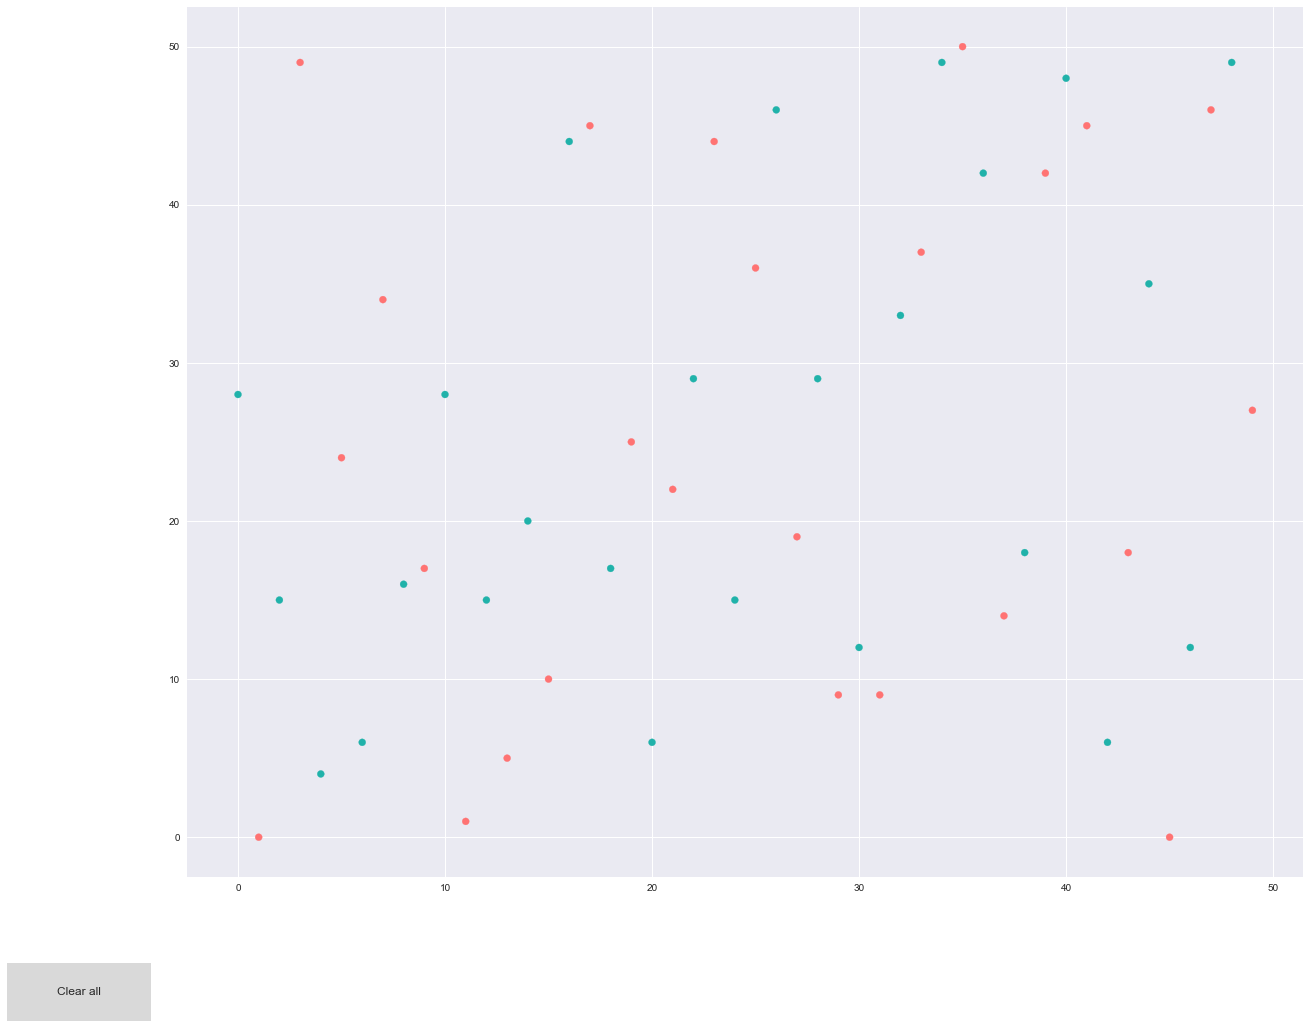

In [34]:

# import the random module since we will use it to generate the data
import random as rnd

# import the main drawing library
import matplotlib.pyplot as plt
from matplotlib.widgets import Button
from matplotlib.text import Annotation

# import the seaborn module which is based on matplotlib to make our visualization more presentable
import seaborn as sns

# set the default style
sns.set()

# define two colors, just to enrich the example
labels_color_map = {0: '#20b2aa', 1: '#ff7373'}

# set the examples count
no_examples = 50

# generate the data needed for the scatterplot
generated_data = [(x, rnd.randint(0, no_examples)) for x in range(0, no_examples)]
generated_labels = ["Label for instance #{0}".format(i) for i in range(0, no_examples)]

print ("now visualizing scatterlplot...")

# add the values one by one to the scatterplot
instances_colors = []
axis_values_x = []
axis_values_y = []
for index, instance in enumerate(generated_data):
    # print instance, index, labels[index]
    coordinate_x, coordinate_y = instance
    color = labels_color_map[index % 2]

    instances_colors.append(color)
    axis_values_x.append(coordinate_x)
    axis_values_y.append(coordinate_y)

# draw a scatter-plot of the generated values
fig = plt.figure(figsize=(20, 16))
ax = plt.subplot()


# extract the scatterplot drawing in a separate function so we ca re-use the code
def draw_scatterplot():
    ax.scatter(
        axis_values_x,
        axis_values_y,
        c=instances_colors,
        picker=True
    )


# draw the initial scatterplot
draw_scatterplot()


# create and add an annotation object (a text label)
def annotate(axis, text, x, y):
    text_annotation = Annotation(text, xy=(x, y), xycoords='data')
    axis.add_artist(text_annotation)


# define the behaviour -> what happens when you pick a dot on the scatterplot by clicking close to it
def onpick(event):
    # step 1: take the index of the dot which was picked
    ind = event.ind

    # step 2: save the actual coordinates of the click, so we can position the text label properly
    label_pos_x = event.mouseevent.xdata
    label_pos_y = event.mouseevent.ydata

    # just in case two dots are very close, this offset will help the labels not appear one on top of each other
    offset = 0

    # if the dots are to close one to another, a list of dots clicked is returned by the matplotlib library
    for i in ind:
        # step 3: take the label for the corresponding instance of the data
        label = generated_labels[i]

        # step 4: log it for debugging purposes
        print (label)

        # step 5: create and add the text annotation to the scatterplot
        annotate(
            ax,
            label,
            label_pos_x + offset,
            label_pos_y + offset
        )

        # step 6: force re-draw
        ax.figure.canvas.draw_idle()

        # alter the offset just in case there are more than one dots affected by the click
        offset += 0.01


# connect the click handler function to the scatterplot
fig.canvas.mpl_connect('pick_event', onpick)

# create the "clear all" button, and place it somewhere on the screen
ax_clear_all = plt.axes([0.0, 0.0, 0.1, 0.05])
button_clear_all = Button(ax_clear_all, 'Clear all')


# define the "clear all" behaviour
def onclick(event):
    # step 1: we clear all artist object of the scatter plot
    ax.cla()

    # step 2: we re-populate the scatterplot only with the dots not the labels
    draw_scatterplot()

    # step 3: we force re-draw
    ax.figure.canvas.draw_idle()


# link the event handler function to the click event on the button
button_clear_all.on_clicked(onclick)

# initial drawing of the scatterplot
plt.plot()
print ("scatterplot done")

# present the scatterplot
plt.show()


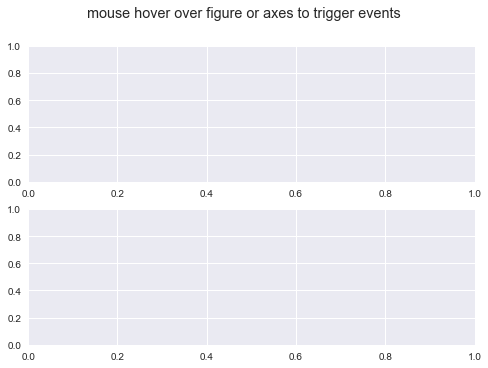

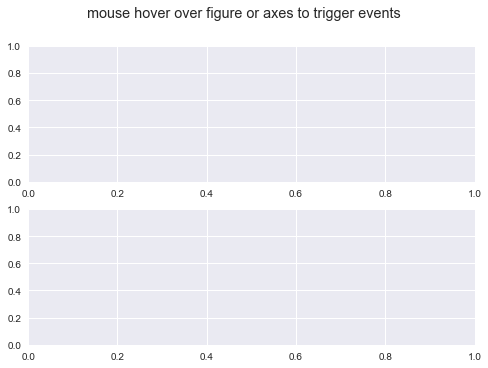

In [35]:
"""
Illustrate the figure and axes enter and leave events by changing the
frame colors on enter and leave
"""
import matplotlib.pyplot as plt

def enter_axes(event):
    print('enter_axes', event.inaxes)
    event.inaxes.patch.set_facecolor('yellow')
    event.canvas.draw()

def leave_axes(event):
    print('leave_axes', event.inaxes)
    event.inaxes.patch.set_facecolor('white')
    event.canvas.draw()

def enter_figure(event):
    print('enter_figure', event.canvas.figure)
    event.canvas.figure.patch.set_facecolor('red')
    event.canvas.draw()

def leave_figure(event):
    print('leave_figure', event.canvas.figure)
    event.canvas.figure.patch.set_facecolor('grey')
    event.canvas.draw()

fig1 = plt.figure()
fig1.suptitle('mouse hover over figure or axes to trigger events')
ax1 = fig1.add_subplot(211)
ax2 = fig1.add_subplot(212)

fig1.canvas.mpl_connect('figure_enter_event', enter_figure)
fig1.canvas.mpl_connect('figure_leave_event', leave_figure)
fig1.canvas.mpl_connect('axes_enter_event', enter_axes)
fig1.canvas.mpl_connect('axes_leave_event', leave_axes)

fig2 = plt.figure()
fig2.suptitle('mouse hover over figure or axes to trigger events')
ax1 = fig2.add_subplot(211)
ax2 = fig2.add_subplot(212)

fig2.canvas.mpl_connect('figure_enter_event', enter_figure)
fig2.canvas.mpl_connect('figure_leave_event', leave_figure)
fig2.canvas.mpl_connect('axes_enter_event', enter_axes)
fig2.canvas.mpl_connect('axes_leave_event', leave_axes)

plt.show()

In [36]:
matplotlib.__version__

'2.0.0'

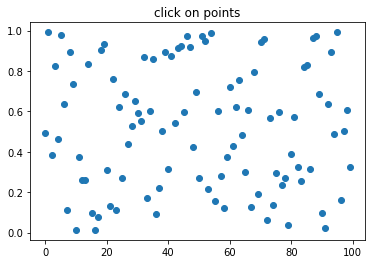

In [57]:
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title('click on points')

line, = ax.plot(np.random.rand(100), 'o', picker=5)  # 5 points tolerance

def onpick(event):
    thisline = event.artist
    xdata = thisline.get_xdata()
    ydata = thisline.get_ydata()
    ind = event.ind
    points = tuple(zip(xdata[ind], ydata[ind]))
    print('onpick points:', points)

fig.canvas.mpl_connect('pick_event', onpick)

plt.show()

In [60]:
# import the random module since we will use it to generate the data
import random as rnd

# import the main drawing library
import matplotlib.pyplot as plt
from matplotlib.widgets import Button
from matplotlib.text import Annotation

# import the seaborn module which is based on matplotlib to make our visualization more presentable
import seaborn as sns

# set the default style
sns.set()

# define two colors, just to enrich the example
labels_color_map = {0: '#20b2aa', 1: '#ff7373'}

# set the examples count
no_examples = 50

# generate the data needed for the scatterplot
generated_data = [(x, rnd.randint(0, no_examples)) for x in range(0, no_examples)]
generated_labels = ["Label for instance #{0}".format(i) for i in range(0, no_examples)]

print ("now visualizing scatterlplot...")

# add the values one by one to the scatterplot
instances_colors = []
axis_values_x = []
axis_values_y = []
for index, instance in enumerate(generated_data):
    # print instance, index, labels[index]
    coordinate_x, coordinate_y = instance
    color = labels_color_map[index % 2]

    instances_colors.append(color)
    axis_values_x.append(coordinate_x)
    axis_values_y.append(coordinate_y)

# draw a scatter-plot of the generated values
fig = plt.figure(figsize=(20, 16))
ax = plt.subplot()


# extract the scatterplot drawing in a separate function so we ca re-use the code
def draw_scatterplot():
    ax.scatter(
        axis_values_x,
        axis_values_y,
        c=instances_colors,
        picker=True
    )


# draw the initial scatterplot
draw_scatterplot()


# create and add an annotation object (a text label)
def annotate(axis, text, x, y):
    text_annotation = Annotation(text, xy=(x, y), xycoords='data')
    axis.add_artist(text_annotation)


# define the behaviour -> what happens when you pick a dot on the scatterplot by clicking close to it
def onpick(event):
    # step 1: take the index of the dot which was picked
    ind = event.ind

    # step 2: save the actual coordinates of the click, so we can position the text label properly
    label_pos_x = event.mouseevent.xdata
    label_pos_y = event.mouseevent.ydata

    # just in case two dots are very close, this offset will help the labels not appear one on top of each other
    offset = 0

    # if the dots are to close one to another, a list of dots clicked is returned by the matplotlib library
    for i in ind:
        # step 3: take the label for the corresponding instance of the data
        label = generated_labels[i]

        # step 4: log it for debugging purposes
        print ("index", i, label)

        # step 5: create and add the text annotation to the scatterplot
        annotate(
            ax,
            label,
            label_pos_x + offset,
            label_pos_y + offset
        )

        # step 6: force re-draw
        ax.figure.canvas.draw_idle()

        # alter the offset just in case there are more than one dots affected by the click
        offset += 0.01


# connect the click handler function to the scatterplot
fig.canvas.mpl_connect('pick_event', onpick)

# create the "clear all" button, and place it somewhere on the screen
ax_clear_all = plt.axes([0.0, 0.0, 0.1, 0.05])
button_clear_all = Button(ax_clear_all, 'Clear all')


# define the "clear all" behaviour
def onclick(event):
    # step 1: we clear all artist object of the scatter plot
    ax.cla()

    # step 2: we re-populate the scatterplot only with the dots not the labels
    draw_scatterplot()

    # step 3: we force re-draw
    ax.figure.canvas.draw_idle()


# link the event handler function to the click event on the button
button_clear_all.on_clicked(onclick)

# initial drawing of the scatterplot
plt.plot()
print ("scatterplot done")

# present the scatterplot
plt.show()

ImportError: No module named 'seaborn'

# show flowplot

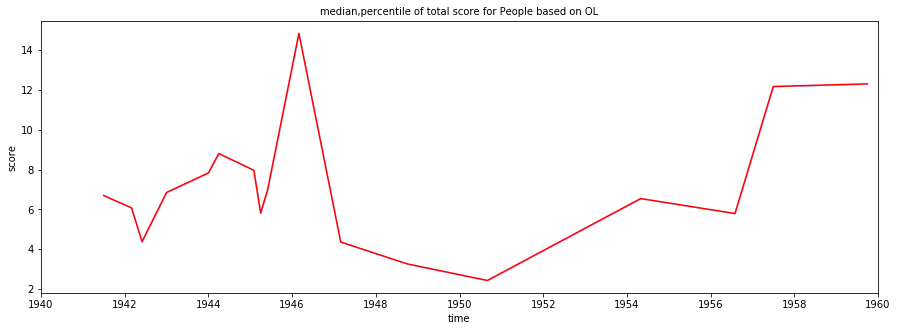

In [72]:
# plot function
def flowplot_percentiles(lexicon,sentiment,group,geo,domain,unit,timeRange_start,timeRange_end=None):
    # lexicon: OL, MPQA, LIWC, ANEW
    # sentiment: pos, neg, total
    # group: People, Events
    # geo: [continent,country] country could be 'all'
    # domain: Articles, Talks
    # unit: 'year' or 'month'
    # timeRange_start: [year,month,date],e.g. [1990,1,1]
    # timeRange_end: same as above, by default it is today
    
    # prepare showed dates depending on time range
    start_yy,start_mm,start_dd = timeRange_start
    start_date = date(start_yy,start_mm,start_dd)
    end_date = date.today()
    if timeRange_end:
        end_yy,end_mm,end_dd = timeRange_end
        end_date = date(end_yy,end_mm,end_dd)
#     print ("start date of x-axis: %s"%(start_date))
#     print ("end date x-axis: %s"%(end_date))

    xaxis_value = [day for day in rrule.rrule(rrule.DAILY,dtstart=start_date,until=end_date)]
    #print ("value for x-axis looks like this: \n%s \nlen(x-axis): %d"%(xaxis_value[-1],len(xaxis_value)))
    
    fig = plt.figure(figsize=(15,5))
    ax = plt.subplot()
    df = None
    
    # choose corresponding dataframe depend on domain and group
    if domain == "Articles":
        if group == "People":
            df = a_people
        elif group == "Events":
            df = a_events
    elif domain == "Talks":
        if group == "People":
            df = t_people
        elif group == "Events":
            df = t_events
        df = article_df


        
    # filter out entities based on geo
    continent,country = geo
    # if continent == 'all', do nothing
    if not continent == 'all':
        if country == 'all':
            # filter out entities with target continent
            df = df[df['continent']==continent]
        else:
            # filter out entities with target country
            df = df[df['country']==country]

          
    # add target unit and corresponding datetime type for entities
    if unit == "month":
        df = add_month_column(df)
    elif unit == "year":
        df = add_year_column(df)
    # we need datetime type because we use it to filter out entities within time range
    df = add_datetime_column(df,unit)
    
    # filter out entities based on time range
    df = df[df["datetime_"+unit].isin(xaxis_value)]
    
    # get score depending on lexicon and sentiment
    if sentiment == "total":
        df = df.assign(total=df["pos_score_"+lexicon]+df["neg_score_"+lexicon])
        score_column = "total"
    else:
        score_column = sentiment+"_score_"+lexicon

        
    # plot flowplot    
    # get median
    df_median = score_median_group_by_column(df,unit,score_column)
    df_median = add_datetime_column(df_median,unit)
    df_25percentile = score_percentile_group_by_column(df,unit,score_column,0.25)
    df_75percentile = score_percentile_group_by_column(df,unit,score_column,0.75)
    
    # plot flowplot
    ax.plot(df_median['datetime_'+unit],df_median[score_column],'r-')
    temp_x = df_median['datetime_'+unit]
    temp_x = pd.Series.as_matrix(temp_x)
    ax.fill_between(temp_x,df_25percentile[score_column],df_75percentile[score_column],color='b',alpha=0.2)



        
#     # plot boxplot
#     print (len(df))
    
#     bp_axes,bp_dict = df.boxplot(column=score_column,by=unit,return_type='both',figsize=(15,10))
#     print ("here")
    
    # set ax
    myfontsize = 10
    ax.set_title("median,percentile of "+sentiment+" score for "+group+" based on "+lexicon,fontsize=myfontsize)
    ax.set_xlabel('time')
    ax.set_ylabel('score')
    ax.set_xlim([start_date,end_date])
#     [[item.set_color('b') for item in bp_dict[key]['boxes']] for key in bp.keys()]
#     [[item.set_color('b') for item in bp_dict[key]['whiskers']] for key in bp.keys()]
#     [[item.set_color('r') for item in bp_dict[key]['medians']] for key in bp.keys()]
    
#     for tick in bp_axes.get_xticklabels():
#                 tick.set_rotation(90)
    plt.show()
    
flowplot_percentiles("OL","total","People",["Europe","all"],"Articles","month",[1940,1,1],[1960,1,1])

# box plot

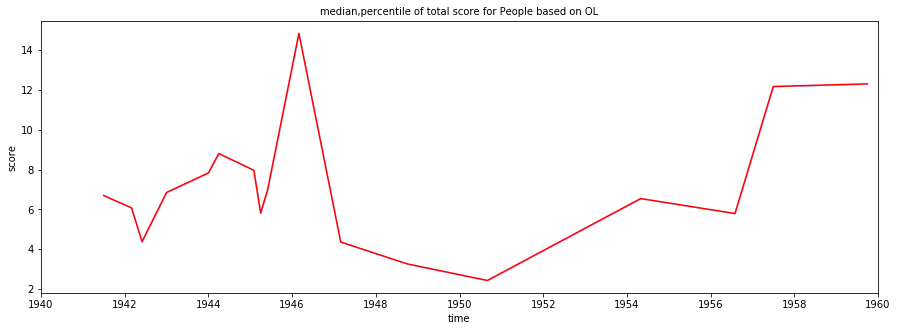

In [72]:
# plot function
def flowplot_percentiles(lexicon,sentiment,group,geo,domain,unit,timeRange_start,timeRange_end=None):
    # lexicon: OL, MPQA, LIWC, ANEW
    # sentiment: pos, neg, total
    # group: People, Events
    # geo: [continent,country] country could be 'all'
    # domain: Articles, Talks
    # unit: 'year' or 'month'
    # timeRange_start: [year,month,date],e.g. [1990,1,1]
    # timeRange_end: same as above, by default it is today
    
    # prepare showed dates depending on time range
    start_yy,start_mm,start_dd = timeRange_start
    start_date = date(start_yy,start_mm,start_dd)
    end_date = date.today()
    if timeRange_end:
        end_yy,end_mm,end_dd = timeRange_end
        end_date = date(end_yy,end_mm,end_dd)
#     print ("start date of x-axis: %s"%(start_date))
#     print ("end date x-axis: %s"%(end_date))

    xaxis_value = [day for day in rrule.rrule(rrule.DAILY,dtstart=start_date,until=end_date)]
    #print ("value for x-axis looks like this: \n%s \nlen(x-axis): %d"%(xaxis_value[-1],len(xaxis_value)))
    
    fig = plt.figure(figsize=(15,5))
    ax = plt.subplot()
    df = None
    
    # choose corresponding dataframe depend on domain and group
    if domain == "Articles":
        if group == "People":
            df = a_people
        elif group == "Events":
            df = a_events
    elif domain == "Talks":
        if group == "People":
            df = t_people
        elif group == "Events":
            df = t_events
        df = article_df


        
    # filter out entities based on geo
    continent,country = geo
    # if continent == 'all', do nothing
    if not continent == 'all':
        if country == 'all':
            # filter out entities with target continent
            df = df[df['continent']==continent]
        else:
            # filter out entities with target country
            df = df[df['country']==country]

          
    # add target unit and corresponding datetime type for entities
    if unit == "month":
        df = add_month_column(df)
    elif unit == "year":
        df = add_year_column(df)
    # we need datetime type because we use it to filter out entities within time range
    df = add_datetime_column(df,unit)
    
    # filter out entities based on time range
    df = df[df["datetime_"+unit].isin(xaxis_value)]
    
    # get score depending on lexicon and sentiment
    if sentiment == "total":
        df = df.assign(total=df["pos_score_"+lexicon]+df["neg_score_"+lexicon])
        score_column = "total"
    else:
        score_column = sentiment+"_score_"+lexicon

        
    # plot flowplot    
    # get median
    df_median = score_median_group_by_column(df,unit,score_column)
    df_median = add_datetime_column(df_median,unit)
    df_25percentile = score_percentile_group_by_column(df,unit,score_column,0.25)
    df_75percentile = score_percentile_group_by_column(df,unit,score_column,0.75)
    
    # plot flowplot
    ax.plot(df_median['datetime_'+unit],df_median[score_column],'r-')
    temp_x = df_median['datetime_'+unit]
    temp_x = pd.Series.as_matrix(temp_x)
    ax.fill_between(temp_x,df_25percentile[score_column],df_75percentile[score_column],color='b',alpha=0.2)



        
#     # plot boxplot
#     print (len(df))
    
#     bp_axes,bp_dict = df.boxplot(column=score_column,by=unit,return_type='both',figsize=(15,10))
#     print ("here")
    
    # set ax
    myfontsize = 10
    ax.set_title("median,percentile of "+sentiment+" score for "+group+" based on "+lexicon,fontsize=myfontsize)
    ax.set_xlabel('time')
    ax.set_ylabel('score')
    ax.set_xlim([start_date,end_date])
#     [[item.set_color('b') for item in bp_dict[key]['boxes']] for key in bp.keys()]
#     [[item.set_color('b') for item in bp_dict[key]['whiskers']] for key in bp.keys()]
#     [[item.set_color('r') for item in bp_dict[key]['medians']] for key in bp.keys()]
    
#     for tick in bp_axes.get_xticklabels():
#                 tick.set_rotation(90)
    plt.show()
    
flowplot_percentiles("OL","total","People",["Europe","all"],"Articles","month",[1940,1,1],[1960,1,1])

here


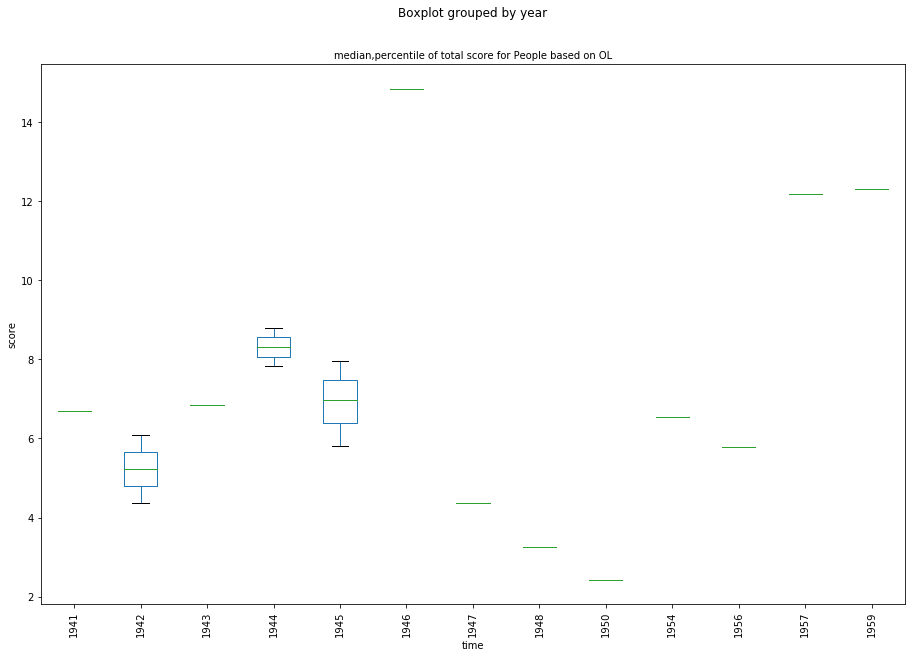

In [73]:
# plot function
def boxplot_percentiles(lexicon,sentiment,group,geo,domain,unit,timeRange_start,timeRange_end=None):
    # lexicon: OL, MPQA, LIWC, ANEW
    # sentiment: pos, neg, total
    # group: People, Events
    # geo: [continent,country] country could be 'all'
    # domain: Articles, Talks
    # unit: 'year' or 'month'
    # timeRange_start: [year,month,date],e.g. [1990,1,1]
    # timeRange_end: same as above, by default it is today
    
    # prepare showed dates depending on time range
    start_yy,start_mm,start_dd = timeRange_start
    start_date = date(start_yy,start_mm,start_dd)
    end_date = date.today()
    if timeRange_end:
        end_yy,end_mm,end_dd = timeRange_end
        end_date = date(end_yy,end_mm,end_dd)
#     print ("start date of x-axis: %s"%(start_date))
#     print ("end date x-axis: %s"%(end_date))

    xaxis_value = [day for day in rrule.rrule(rrule.DAILY,dtstart=start_date,until=end_date)]
    #print ("value for x-axis looks like this: \n%s \nlen(x-axis): %d"%(xaxis_value[-1],len(xaxis_value)))
    
#     fig = plt.figure(figsize=(15,5))
#     ax = plt.subplot()
    df = None
    
    # choose corresponding dataframe depend on domain and group
    if domain == "Articles":
        if group == "People":
            df = a_people
        elif group == "Events":
            df = a_events
    elif domain == "Talks":
        if group == "People":
            df = t_people
        elif group == "Events":
            df = t_events
        df = article_df


        
    # filter out entities based on geo
    continent,country = geo
    # if continent == 'all', do nothing
    if not continent == 'all':
        if country == 'all':
            # filter out entities with target continent
            df = df[df['continent']==continent]
        else:
            # filter out entities with target country
            df = df[df['country']==country]

          
    # add target unit and corresponding datetime type for entities
    if unit == "month":
        df = add_month_column(df)
    elif unit == "year":
        df = add_year_column(df)
    # we need datetime type because we use it to filter out entities within time range
    df = add_datetime_column(df,unit)
    
    # filter out entities based on time range
    df = df[df["datetime_"+unit].isin(xaxis_value)]
    
    # get score depending on lexicon and sentiment
    if sentiment == "total":
        df = df.assign(total=df["pos_score_"+lexicon]+df["neg_score_"+lexicon])
        score_column = "total"
    else:
        score_column = sentiment+"_score_"+lexicon


        
#     # plot boxplot
#     print (len(df))
    
    bp_axes = df.boxplot(column=score_column,by=unit,grid=False,figsize=(15,10))#,return_type='both'
    print ("here")
    
#     # set ax
    myfontsize = 10
    bp_axes.set_title("median,percentile of "+sentiment+" score for "+group+" based on "+lexicon,fontsize=10)
    bp_axes.set_xlabel('time')
    bp_axes.set_ylabel('score')
    #bp_axes.set_xlim([start_date,end_date])
#     [[item.set_color('b') for item in bp_dict[key]['boxes']] for key in bp.keys()]
#     [[item.set_color('b') for item in bp_dict[key]['whiskers']] for key in bp.keys()]
#     [[item.set_color('r') for item in bp_dict[key]['medians']] for key in bp.keys()]
    
    for tick in bp_axes.get_xticklabels():
                tick.set_rotation(90)
    return bp_axes
    
boxplot_percentiles("OL","total","People",["Europe","all"],"Articles","year",[1940,1,1],[1960,1,1])

In [10]:
# prepare everything for boxplot
def prepare_boxplot_percentiles(lexicon,sentiment,group,geo,domain,unit,timeRange_start,timeRange_end=None):
    # lexicon: OL, MPQA, LIWC, ANEW
    # sentiment: pos, neg, total
    # group: People, Events
    # geo: [continent,country] country could be 'all'
    # domain: Articles, Talks
    # unit: 'year' or 'month'
    # timeRange_start: [year,month,date],e.g. [1990,1,1]
    # timeRange_end: same as above, by default it is today
    
    # prepare showed dates depending on time range
    start_yy,start_mm,start_dd = timeRange_start
    start_date = date(start_yy,start_mm,start_dd)
    end_date = date.today()
    if timeRange_end:
        end_yy,end_mm,end_dd = timeRange_end
        end_date = date(end_yy,end_mm,end_dd)
#     print ("start date of x-axis: %s"%(start_date))
#     print ("end date x-axis: %s"%(end_date))

    xaxis_value = [day for day in rrule.rrule(rrule.DAILY,dtstart=start_date,until=end_date)]
    #print ("value for x-axis looks like this: \n%s \nlen(x-axis): %d"%(xaxis_value[-1],len(xaxis_value)))
    
#     fig = plt.figure(figsize=(15,5))
#     ax = plt.subplot()
    df = None
    
    # choose corresponding dataframe depend on domain and group
    if domain == "Articles":
        if group == "People":
            df = a_people
        elif group == "Events":
            df = a_events
    elif domain == "Talks":
        if group == "People":
            df = t_people
        elif group == "Events":
            df = t_events
        df = article_df


        
    # filter out entities based on geo
    continent,country = geo
    # if continent == 'all', do nothing
    if not continent == 'all':
        if country == 'all':
            # filter out entities with target continent
            df = df[df['continent']==continent]
        else:
            # filter out entities with target country
            df = df[df['country']==country]

          
    # add target unit and corresponding datetime type for entities
    if unit == "month":
        df = add_month_column(df)
    elif unit == "year":
        df = add_year_column(df)
    # we need datetime type because we use it to filter out entities within time range
    df = add_datetime_column(df,unit)
    
    # filter out entities based on time range
    df = df[df["datetime_"+unit].isin(xaxis_value)]
    
    # get score depending on lexicon and sentiment
    if sentiment == "total":
        df = df.assign(total=df["pos_score_"+lexicon]+df["neg_score_"+lexicon])
        score_column = "total"
    else:
        score_column = sentiment+"_score_"+lexicon


        
# #     # plot boxplot
# #     print (len(df))
    
#     bp_axes = df.boxplot(column=score_column,by=unit,grid=False,figsize=(15,10))#,return_type='both'
#     print ("here")
    
# #     # set ax
#     myfontsize = 10
#     bp_axes.set_title("median,percentile of "+sentiment+" score for "+group+" based on "+lexicon,fontsize=10)
#     bp_axes.set_xlabel('time')
#     bp_axes.set_ylabel('score')
#     #bp_axes.set_xlim([start_date,end_date])
# #     [[item.set_color('b') for item in bp_dict[key]['boxes']] for key in bp.keys()]
# #     [[item.set_color('b') for item in bp_dict[key]['whiskers']] for key in bp.keys()]
# #     [[item.set_color('r') for item in bp_dict[key]['medians']] for key in bp.keys()]
    
#     for tick in bp_axes.get_xticklabels():
#                 tick.set_rotation(90)
    return df,score_column
    
#boxplot_percentiles("OL","total","People",["Europe","all"],"Articles","year",[1940,1,1],[1960,1,1])

In [1]:
import plotly

In [2]:
plotly.__version__

'2.0.12'

In [3]:
import plotly.plotly as py
import plotly.graph_objs as go

# Create random data with numpy
import numpy as np

N = 1000
random_x = np.random.randn(N)
random_y = np.random.randn(N)

# Create a trace
trace = go.Scatter(
    x = random_x,
    y = random_y,
    mode = 'markers'
)

data = [trace]

# Plot and embed in ipython notebook!
py.iplot(data, filename='basic-scatter')

# or plot with: plot_url = py.plot(data, filename='basic-line')

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import mpld3

ImportError: No module named 'mpld3'

In [5]:
import matplotlib
matplotlib.__version__

'2.0.0'

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider

start_time = 86930.00
end_time = 86934.00
df = pd.read_csv('Data.csv', delimiter=',')


fig, ax = plt.subplots(1,1)
plt.subplots_adjust(bottom=0.25)
sax = plt.axes([0.25, 0.1, 0.65, 0.03])
slide = Slider(sax, 'time', start_time, end_time, valinit=start_time)

#Initial plot
act_data = df.loc[df['timestamp'] == float(int(start_time))]
s, = ax.plot(act_data.x, act_data.y, 'o')

def update(timestamp):
    act_data = df.loc[df['timestamp'] == float(int(timestamp))]
    X = act_data.x
    Y = act_data.y

    #Update data based on slider
    s.set_xdata(X)
    s.set_ydata(Y)

    #Reset axis limits
    ax.set_xlim([X.min()*0.9,X.max()*1.1])
    ax.set_ylim([Y.min()*0.9,Y.max()*1.1])

    fig.canvas.draw()

slide.on_changed(update)
plt.show()

FileNotFoundError: File b'Data.csv' does not exist